# DTM (Figures 1, 2 and Tables 1, 2)

This is adapted (partially) from https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/dtm_example.ipynb


In [1]:
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
import numpy as np
import pandas as pd

%matplotlib inline

train = True

import json
import re

from gensim.parsing.preprocessing import STOPWORDS

# script author defined stop words
STOPWORDS_ = ['rt', '', 'httpst', 'amp']

# load the tweets
documents = []
time_seq = []
weeknum = ''
ds_fact = 3
with open('../data/c_twitter.json') as f_in:
    for i, l in enumerate(f_in):
        if (i % ds_fact == 0):
            index =+ 1
            c_twt = json.loads(l)

            # remove punctuation and stopwords for this analysis
            words = re.sub(r'[^a-zA-Z\s]', '', c_twt['text'])
            words = words.split()
            words = [w for w in words if (w not in STOPWORDS and w not in STOPWORDS_)]
            words = [bytes(w, 'utf-8') for w in words]

            # c_twt: {'weeknum': str, 'c_text': str, 'tags': [str]}
            documents.append(words)

            if weeknum != c_twt['weeknum']:
                time_seq.append(i // ds_fact)
                weeknum = c_twt['weeknum']
            
time_seq.append(len(documents))
y = time_seq[1:] + [0]
x = time_seq[:]
time_seq = []
for x, y in zip(x, y):
    time_seq.append(y - x)

del time_seq[-1]
time_seq

[23389,
 35897,
 95893,
 35265,
 24185,
 8876,
 22790,
 23839,
 24104,
 22814,
 10384,
 44604,
 24929]

In [2]:
from gensim.models import TfidfModel

dictionary = corpora.Dictionary(documents)
dictionary.filter_extremes(no_below=10, no_above=0.3, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in documents]
# tfidf = TfidfModel(corpus)
# corpus = tfidf[corpus]
len(corpus)

396969

# Train model (or load model from file)

In [3]:
if train:
    dtm_binary_path = '/high_spd_work/sm_w2v/tools/dtm/dtm/dtm'
    model = DtmModel(dtm_binary_path, corpus, time_seq, num_topics=10,
                     id2word=dictionary, initialize_lda=True, rng_seed=0)
    model.save('../models/dtm_example.model')
else:
    model = DtmModel.load('../models/doc2vec.model')

In [4]:
topics = model.show_topic(topicid=3, time=11, topn=20)
topics

[(0.060388591220170013, 'people'),
 (0.039051626720875594, 'living'),
 (0.022705368351089439, 'infection'),
 (0.017119891259110922, 'million'),
 (0.011583836551847996, 'positive'),
 (0.011513688352096445, 'w'),
 (0.011157288347692959, 'years'),
 (0.011069641271090582, 'good'),
 (0.01073306058711308, 'know'),
 (0.0097316736201440227, 'children'),
 (0.0093395907818673643, 'morning'),
 (0.008704366575220222, 'epidemic'),
 (0.0085875469796188493, 'hivaids'),
 (0.008586511057642977, 'aids'),
 (0.0083716882444404388, 'need'),
 (0.0065327047218084822, 'infected'),
 (0.0064746877007617306, 'neighbor'),
 (0.0064263948293922608, 'n'),
 (0.0060562243349574539, 'russia'),
 (0.0058065020440871626, 'signs')]

# Figure 1, 2 and Table 1, 2: Dynamic Topic Modeling

I'm proposing that in figures 1 and 2, we pick 2 topics from the Dynamic Topic Model, and describe the progression in time of these 2 topics with time series graphs, and tables 1 and 2 will be top 10 tables of these same topics over time


Topic ID's 8, 7 and 3 are all interesting

In [5]:
# This cell just gets the week nums (YYYY-WW)
def weeknums():
    # first  week is 2015-47
    week = 47
    year = 2015
    weeknums = []
    for i in range(len(model.time_slices)):
        weeknums.append(str(year) + '-' + str(week))
        week =+ 1

        if week > 53:
            year =+ 1
            week = 1
    return weeknums

weeknums = weeknums()

# Table 1: top 10 words associated with topic ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

In [6]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=3, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability             Word
0     0.075742           people
1     0.057026           living
2     0.043676     worldaidsday
3     0.040491              new
4     0.026256          chronic
5     0.026041  allscienceglobe
6     0.025593          illness
7     0.025161          million
8     0.024116             know
9     0.019981        treatment

--- time slice:  1 

   Probability          Word
0     0.076177        people
1     0.062317        living
2     0.050774  worldaidsday
3     0.030408           new
4     0.025763       million
5     0.022117          know
6     0.021559     infection
7     0.020603       chronic
8     0.020244       illness
9     0.019744     treatment

--- time slice:  2 

   Probability          Word
0     0.072998        people
1     0.066271        living
2     0.055407  worldaidsday
3     0.036624     infection
4     0.023261       million
5     0.018356          know
6     0.017535          aids
7     0.015639         signs
8  

# Figure 1: key terms associated with ID 3 over time

note how 'prep' is absent from top ten in the beginning, then increases over time

/high_spd_work/sm_w2v/venv/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/high_spd_work/sm_w2v/venv/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


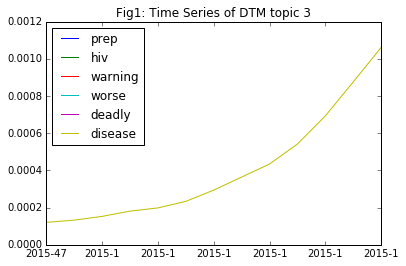

In [7]:
# needs to be re-run. Use tf-idf
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=3, time=t_index, topn=1000)
        
    columns = ['prep', 'hiv', 'warning', 'worse', 'deadly', 'disease']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)
    
df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='Fig1: Time Series of DTM topic 3')
fig = ax.get_figure()
fig.savefig('Fig1: Time Series of DTM topic 3.pdf', format='pdf')

# Table 2: top 10 words associated with topic ID 8 over time
Note how at time points 2 and 3 we get world AIDS day related words. At time points 7, 8 and 9 the antibiotic 'Zithromax' appears, then disappears. 'gay' also seems to come up during the later time points, which parallels the #egaylity in the Doc2Vec results. 'rt' is not entirely interesting, since it is the name of a news agency.

In [8]:
for t_index in range(len(model.time_slices)):
    print("--- time slice: ", t_index, "\n")
    print(pd.DataFrame(model.show_topic(topicid=8, time=t_index, topn=10), columns=['Probability', 'Word']))
    print()

--- time slice:  0 

   Probability      Word
0     0.024801      aids
1     0.021127     treat
2     0.018408    africa
3     0.017742      save
4     0.017073  millions
5     0.016977      link
6     0.015360   hivaids
7     0.015113  diseases
8     0.014666      join
9     0.013968     asked

--- time slice:  1 

   Probability      Word
0     0.028185      aids
1     0.022087     treat
2     0.020473    africa
3     0.018101      save
4     0.017774  millions
5     0.015395      join
6     0.014484    people
7     0.013886   hivaids
8     0.013821      link
9     0.013628      push

--- time slice:  2 

   Probability             Word
0     0.032606             aids
1     0.022898            treat
2     0.021268           africa
3     0.017995         millions
4     0.017824             save
5     0.016086           people
6     0.015605             join
7     0.014160             push
8     0.012961              wad
9     0.012655  treatmentforall

--- time slice:  3 

   Probabil

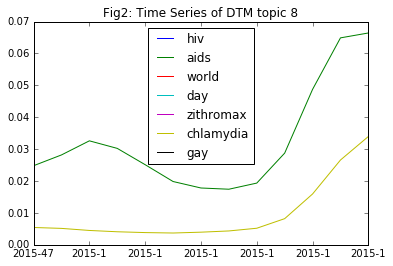

In [9]:
# needs to be re-run. Use tf-idf
data = []
for t_index in range(len(model.time_slices)):
    words = model.show_topic(topicid=8, time=t_index, topn=1000)
        
    columns = ['hiv', 'aids', 'world', 'day', 'zithromax', 'chlamydia', 'gay']
    row = []
    for col in columns:
        cell = [w[0] for w in words if w[1] == col]
        if not cell:
            cell = .000001
        else:
            cell = cell[0]
        row.append(cell)
    data.append(row)


df = pd.DataFrame(data, columns=columns, index=weeknums)
ax = df.plot(title='Fig2: Time Series of DTM topic 8')
fig = ax.get_figure()
fig.savefig('Fig2: Time Series of DTM topic 8.pdf', format='pdf')